<a href="https://colab.research.google.com/github/aryamanpandya99/AIFundamentals/blob/master/MLPy/autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

By definition, an autoencoder is a neural network trained to downsize then reconstruct its input data from a latent representation. A convolutional autoencoder uses a CNN encoder to compress the input into the a latent representation and a deconvolutional (transposed convolution) decoder to reconstruct the input from the latent representation.

In [164]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [165]:
import pickle, gzip, math, os, time, shutil, torch, matplotlib.pyplot as plt, numpy as np

In [166]:
import pandas as pd
import pathlib as Path
from torch.utils.data import DataLoader, default_collate, Dataset
from typing import Mapping

In [167]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [168]:
all_batches_data = []
all_batches_labels = []

for i in range(1, 6):
    with open(f'/content/drive/MyDrive/data/cifar-10-batches-py/data_batch_{i}', 'rb') as f:
        dataset_dict = pickle.load(f, encoding='bytes')
        all_batches_data.append(dataset_dict[b'data'])
        all_batches_labels.append(dataset_dict[b'labels'])

stacked_data = np.vstack(all_batches_data)
stacked_labels = np.hstack(all_batches_labels)

In [169]:
data = torch.tensor(stacked_data, dtype=torch.float32).view(-1, 3, 32, 32).to(device) / 255.
labels = torch.tensor(stacked_labels, dtype=torch.long).to(device)

split_idx = int(0.8 * len(data))

x_train, x_valid = data[:split_idx], data[split_idx:]
y_train, y_valid = labels[:split_idx], labels[split_idx:]

print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)

print("Validation data shape:", x_valid.shape)
print("Validation labels shape:", y_valid.shape)

Training data shape: torch.Size([40000, 3, 32, 32])
Training labels shape: torch.Size([40000])
Validation data shape: torch.Size([10000, 3, 32, 32])
Validation labels shape: torch.Size([10000])


In [170]:
# sample cnn
from torch import nn

simple_cnn = nn.Sequential(
    nn.Conv2d(3, 4, kernel_size=3, stride=2, padding=1),    # 14x14x4
    nn.ReLU(),
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),    # 7x7x8
    nn.ReLU(),
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),    # 4x4x16
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),    # 2x2x16
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),    # 1x1x10
    nn.Flatten(),
).to(device)

simple_cnn(x_train[0].unsqueeze(0))

tensor([[-0.0199,  0.0211, -0.0202, -0.0078, -0.0296, -0.0655,  0.0820, -0.0219,
         -0.0680,  0.0308]], device='cuda:0', grad_fn=<ViewBackward0>)

In [171]:
def show_torch_image(img):
    img = img.permute(1, 2, 0)
    img = img.numpy().astype(np.uint8)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

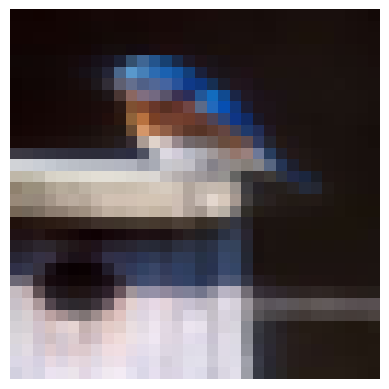

In [172]:
show_torch_image(255 * x_train[13].cpu())

In [195]:
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(24, 48, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 96, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(96, 48, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(48, 24, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)

In [196]:
def validate(model, loss_func, valid_dl):
    model.eval()
    with torch.no_grad():
        tot_loss = 0.
        count = 0
        for xb, _ in valid_dl:
            pred = model(xb)
            loss = loss_func(pred, xb)
            tot_loss += loss.item()
            count += len(xb)
    return tot_loss / count

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        model.train()
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, xb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        tot_loss_count = validate(model, loss_func, valid_dl)
        print(f"Validation loss: {tot_loss_count}")

In [197]:
class CIFARCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [198]:
train_ds = CIFARCustomDataset(x_train, y_train)
valid_ds = CIFARCustomDataset(x_valid, y_valid)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True)

In [199]:
print(len(train_ds))

40000


In [200]:
print(next(iter(train_dl))[0].shape)
print(next(iter(train_dl))[1].shape)

torch.Size([32, 3, 32, 32])
torch.Size([32])


In [201]:
model = ConvolutionalAutoencoder()
loss_func = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [202]:
model.to(device)

ConvolutionalAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(96, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(48, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(24, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [203]:
fit(20, model, loss_func, opt, train_dl, valid_dl)

Epoch 1/20
Validation loss: 0.00016715352768078447
Epoch 2/20
Validation loss: 0.00012940268230158836
Epoch 3/20
Validation loss: 9.362535222899169e-05
Epoch 4/20
Validation loss: 7.328917270060628e-05
Epoch 5/20
Validation loss: 6.071821653749794e-05
Epoch 6/20
Validation loss: 5.3354900935664774e-05
Epoch 7/20
Validation loss: 5.003379643894732e-05
Epoch 8/20
Validation loss: 4.379688269691542e-05
Epoch 9/20
Validation loss: 4.245228574145585e-05
Epoch 10/20
Validation loss: 3.834330629324541e-05
Epoch 11/20
Validation loss: 4.8527628788724544e-05
Epoch 12/20
Validation loss: 3.6489685345441106e-05
Epoch 13/20
Validation loss: 3.416006008046679e-05
Epoch 14/20
Validation loss: 3.1081737752538174e-05
Epoch 15/20
Validation loss: 2.957239233655855e-05
Epoch 16/20
Validation loss: 3.088631210848689e-05
Epoch 17/20
Validation loss: 2.7132819179678335e-05
Epoch 18/20
Validation loss: 2.6576519198715685e-05
Epoch 19/20
Validation loss: 2.461595800705254e-05
Epoch 20/20
Validation loss: 2.4

torch.Size([1, 3, 32, 32])


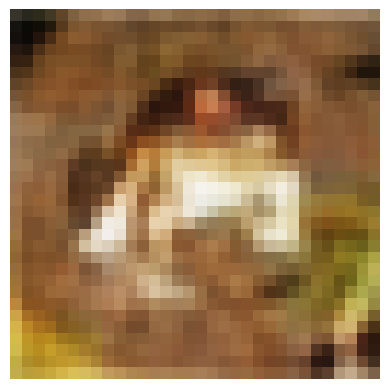

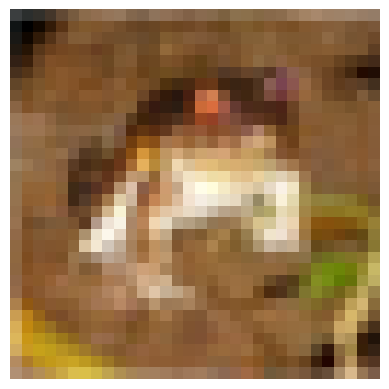

In [204]:
sample_output = model(x_train[0].unsqueeze(0))
print(sample_output.shape)
show_torch_image(255*sample_output.squeeze(0).detach().cpu())
show_torch_image(255 * x_train[0].cpu())

In [205]:
opt = torch.optim.Adam(model.parameters(), lr=0.0001)
fit(20, model, loss_func, opt, train_dl, valid_dl)

Epoch 1/20
Validation loss: 2.188009995734319e-05
Epoch 2/20
Validation loss: 2.166193930897862e-05
Epoch 3/20
Validation loss: 2.1274357271613552e-05
Epoch 4/20
Validation loss: 2.114892888930626e-05
Epoch 5/20
Validation loss: 2.080260631046258e-05
Epoch 6/20
Validation loss: 2.0561565138632433e-05
Epoch 7/20
Validation loss: 2.034807674936019e-05
Epoch 8/20
Validation loss: 2.022644015669357e-05
Epoch 9/20
Validation loss: 2.0063350148848258e-05
Epoch 10/20
Validation loss: 1.9822043683961966e-05
Epoch 11/20
Validation loss: 1.959147836896591e-05
Epoch 12/20
Validation loss: 1.944143220607657e-05
Epoch 13/20
Validation loss: 1.9282024106360042e-05
Epoch 14/20
Validation loss: 1.911841388500761e-05
Epoch 15/20
Validation loss: 1.8994702491909266e-05
Epoch 16/20
Validation loss: 1.8928385138860903e-05
Epoch 17/20
Validation loss: 1.8643813519156537e-05
Epoch 18/20
Validation loss: 1.8652658868813888e-05
Epoch 19/20
Validation loss: 1.8393395724706352e-05
Epoch 20/20
Validation loss: 1

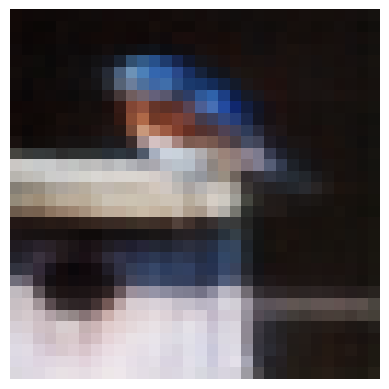

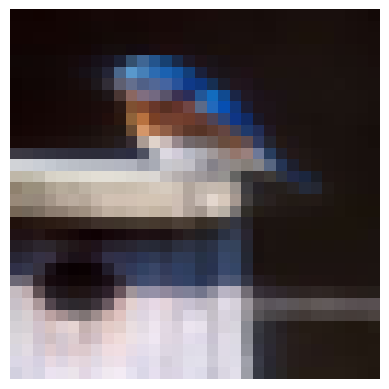

In [208]:
with torch.no_grad():
    sample_output = model(x_train[13].unsqueeze(0))
    show_torch_image(255*sample_output.squeeze(0).detach().cpu())
    show_torch_image(255 * x_train[13].cpu())

## Observations

1. The more we compress with the encoder, the harder it gets to decode with the decoder. This makes sense intuitively, but still needed to be observed practically.

2. A learning rate decay helped marginally, but not substantially. In the above implementation, we might want to try out different tricks to improve model performance (like batch norm, dropout)

3. At first, we only trained our model with 10000 images. For 32x32x3 sized images, this is relatively low. Including images from other batches showed an improvement in the fidelity of the output, and a reduction in the loss. This too, however, seems marginal.

4. Additional non-compressive layers don't seem to help given the current dataset size constraints.

5. Increasing model width (by way of increasing number of kernels per conv layer) led to a significant improvement in performance.
